# **Data Download**

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=74b9d4feafc36203919afbb9a74f89d94ed8afd12e251990dbbc14bcc8fa474d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import os
import zipfile
import pandas as pd
import cv2
from cv2 import imread, imshow
from skimage.transform import rescale, resize

In [ ]:
mura_link = 'https://us13.mailchimp.com/mctx/clicks?url=https%3A%2F%2Fcs.stanford.edu%2Fgroup%2Fmlgroup%2FMURA-v1.1.zip&xid=10f4b6a2c4&uid=55365305&pool=contact_facing&subject=MURA-v1.1%3A+Link+To+Dataset&v=1&h=44509d1b80a4e7bee0a0a789810a6e7e8239f861f28079bdf860de1a31439c65'

In [ ]:
if os.path.exists('./mura_data'):
    print("It exists no need to download")
else:
    wget.download(mura_link,'./mura_zip')
    with zipfile.ZipFile('mura_zip', 'r') as zip_ref:
        zip_ref.extractall('./mura_data')

# **Libraries and Functions**

In [ ]:
!pip install keras_preprocessing
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import cv2
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)


from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.layers import Input, Activation,BatchNormalization,Flatten,Dropout,Dense
from tensorflow.keras.layers import Conv2D,SpatialDropout2D,AvgPool2D,MaxPool2D,GlobalAveragePooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy

from tensorflow.keras.applications import ResNet152V2, DenseNet201

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Functions**

In [ ]:
def load_data(path):
    dataset = []

    for body in os.listdir(path):
        body_part = body
        path_to_body_part = path+'/'+str(body)

        for patient in os.listdir(path_to_body_part):
            patient_id = patient
            path_to_patient = path_to_body_part +'/'+str(patient_id)

            for result in os.listdir(path_to_patient):
                if result.split('_')[-1]=='positive':
                    label = 1
                elif result.split('_')[-1]=='negative':
                    label= 0
                path_to_xrays = path_to_patient+'/'+str(result)

                for xray in os.listdir(path_to_xrays):
                    path_to_xray = path_to_xrays + '/' + str(xray)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'xray_path': path_to_xray
                        }
                    )
    return dataset

In [ ]:
def calc_distr(df):
    grouped = df.groupby(df.label)
    pos = len(grouped.get_group(1))
    neg = len(grouped.get_group(0))
    total = len(df)

    return pos, neg, total

In [ ]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [ ]:
#https://github.com/vraul92/Humerus-Bone-Fracture-Detection/blob/master/train__humerus_fracture_detection_keras_model.ipynb
#https://github.com/ag-piyush/Bone-Fracture-Detection---MURA/blob/cfd68b53dd39bd81aa893b4b7cc38c296920f37e/data_loader.py#L52
def image_loader(Path, size = 256):

    Images = []

    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)

        except Exception as e:
            print(str(e))

    Images = np.asarray(Images).astype('float32')

    #normalization
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std

    return Images

In [ ]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [ ]:
def plot_image(image, label):
    plt.imshow(image, cmap = plt.cm.binary)
    if label==1:
        plt.xlabel("Negative")
    else:
        plt.xlabel("Positive")

In [ ]:
def plot_history(hs, epochs, metric):

    if metric=='loss':
                label_y = 'Loss'
    elif metric=='accuracy':
               label_y = 'Accuracy'
    elif metric=='auc':
               label_y = 'AUC'
    else : label_y = 'kappa'


    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

In [ ]:
def print_results(model_name,
                  epochs,
                  hs,
                  model_eval):

    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))


    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

# **Data Exploratory Analysis**

**Global variables**

In [ ]:
img_size = 256
number_of_classes = 2

In [ ]:
# define seed number to have reproducible experiments.
random_seed = 3352024

os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

**Data exploratory analysis**

**Train**

In [ ]:
data = '/content/mura_data/MURA-v1.1/train'
dataset = load_data(data)
df_train = pd.DataFrame(dataset)
df_train['patient_id'] = df_train['patient_id'].apply(lambda x: x.replace('patient',''))

In [ ]:
#Selecting only XR_HUMERUS, XR_SHOULDER
import pandas as pd
filtered_train = df_train[df_train['body_part'].isin(['XR_HUMERUS', 'XR_SHOULDER','XR_FINGER'])]

In [ ]:
filtered_train.sample(3)

,body_part,patient_id,label,xray_path
5604,XR_SHOULDER,01543,0,/content/mura_data/MURA-v1.1/train/XR_SHOULDER...
14504,XR_FINGER,04040,0,/content/mura_data/MURA-v1.1/train/XR_FINGER/p...
12401,XR_FINGER,03699,1,/content/mura_data/MURA-v1.1/train/XR_FINGER/p...


In [ ]:
body_parts = np.unique(df_train['body_part'])

In [ ]:
distr = []
for i in range(len(body_parts)):
    pos, neg, total=calc_distr(df_train[df_train['body_part']==body_parts[i]])
    distr.append(
        {
            'body_part': body_parts[i],
            'positive': pos,
            'negative': neg,
            'total':total
        })

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

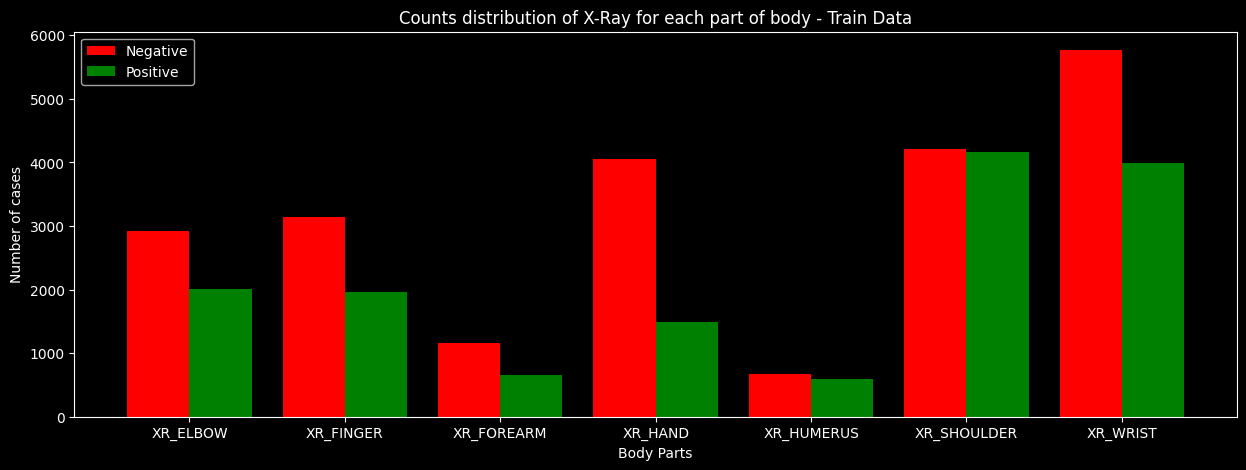

In [ ]:
df_train_distr = pd.DataFrame(distr)
df_train_distr['percentage'] = round(100 * df_train_distr['total'] / len(df_train['body_part']), 2)

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = df_train_distr['body_part']
negative = df_train_distr['negative']
positive = df_train_distr['positive']

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize=(15,5))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative', color='red')
rects2 = ax.bar(x + width/2, positive, width, label='Positive', color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of cases')
ax.set_xlabel('Body Parts',fontsize=10)
ax.set_title('Counts distribution of X-Ray for each part of body - Train Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


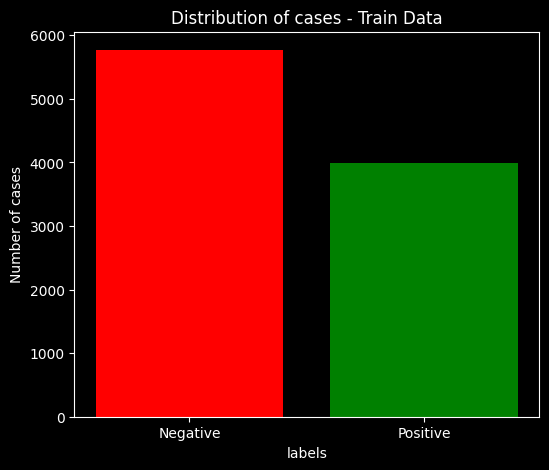

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.bar(["Negative"], [neg], color='red')
plt.bar(["Positive"], [pos], color='green')

plt.title('Distribution of cases - Train Data')
plt.xlabel('labels')
plt.ylabel('Number of cases')


plt.show()

In [ ]:
X_train = image_loader(filtered_train['xray_path'], img_size)

100%|██████████| 14757/14757 [00:48<00:00, 302.42it/s]


**Test**

In [ ]:
data = '/content/mura_data/MURA-v1.1/valid'
dataset = load_data(data)
df_test = pd.DataFrame(dataset)
df_test['patient_id'] = df_test['patient_id'].apply(lambda x: x.replace('patient',''))

In [ ]:
#Selecting only XR_HUMERUS, XR_SHOULDER
import pandas as pd
filtered_test = df_test[df_test['body_part'].isin(['XR_HUMERUS', 'XR_SHOULDER','XR_FINGER'])]

In [ ]:
filtered_test.sample(3)

,body_part,patient_id,label,xray_path
313,XR_SHOULDER,11578,1,/content/mura_data/MURA-v1.1/valid/XR_SHOULDER...
697,XR_SHOULDER,11732,1,/content/mura_data/MURA-v1.1/valid/XR_SHOULDER...
374,XR_SHOULDER,11715,1,/content/mura_data/MURA-v1.1/valid/XR_SHOULDER...


In [ ]:
body_parts = np.unique(df_test['body_part'])

In [ ]:
distr = []
for i in range(len(body_parts)):
    pos, neg, total=calc_distr(df_test[df_test['body_part']==body_parts[i]])
    distr.append(
        {
            'body_part': body_parts[i],
            'positive': pos,
            'negative': neg,
            'total':total
        })

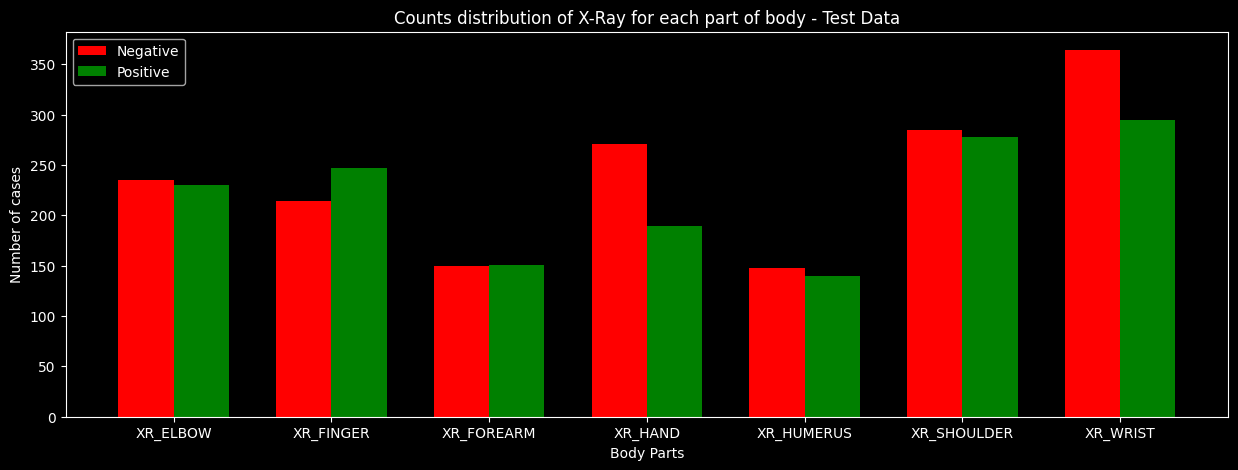

In [ ]:
df_test_distr = pd.DataFrame(distr)
df_test_distr['percentage'] = round(100 * df_test_distr['total'] / len(df_test['body_part']), 2)

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = df_test_distr['body_part']
negative = df_test_distr['negative']
positive = df_test_distr['positive']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(15, 5))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative', color='red')
rects2 = ax.bar(x + width/2, positive, width, label='Positive', color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of cases')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray for each part of body - Test Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

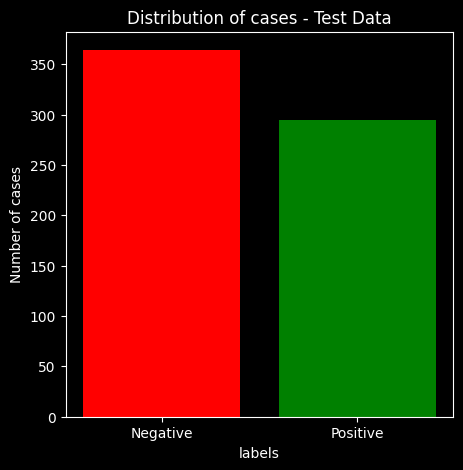

In [ ]:
fig = plt.figure(figsize=(5, 5))

plt.bar(["Negative"], [neg], color='red')
plt.bar(["Positive"], [pos], color='green')

plt.title('Distribution of cases - Test Data')
plt.xlabel('labels')
plt.ylabel('Number of cases')


plt.show()

**Plots of XR**

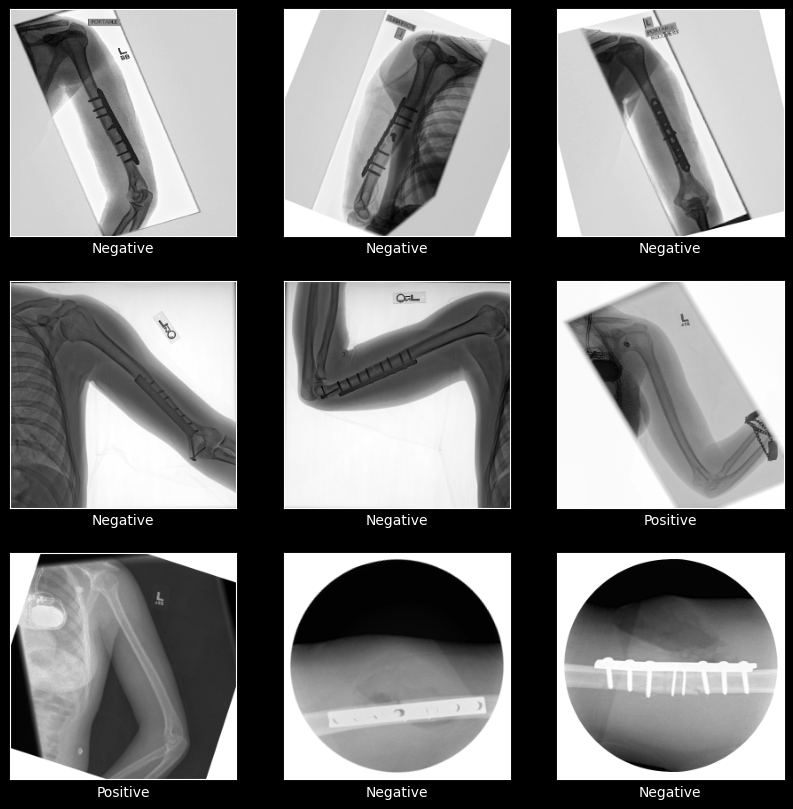

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])### Plots
    plt.yticks([])
    plot_image(X_train[i], df_train['label'][i])

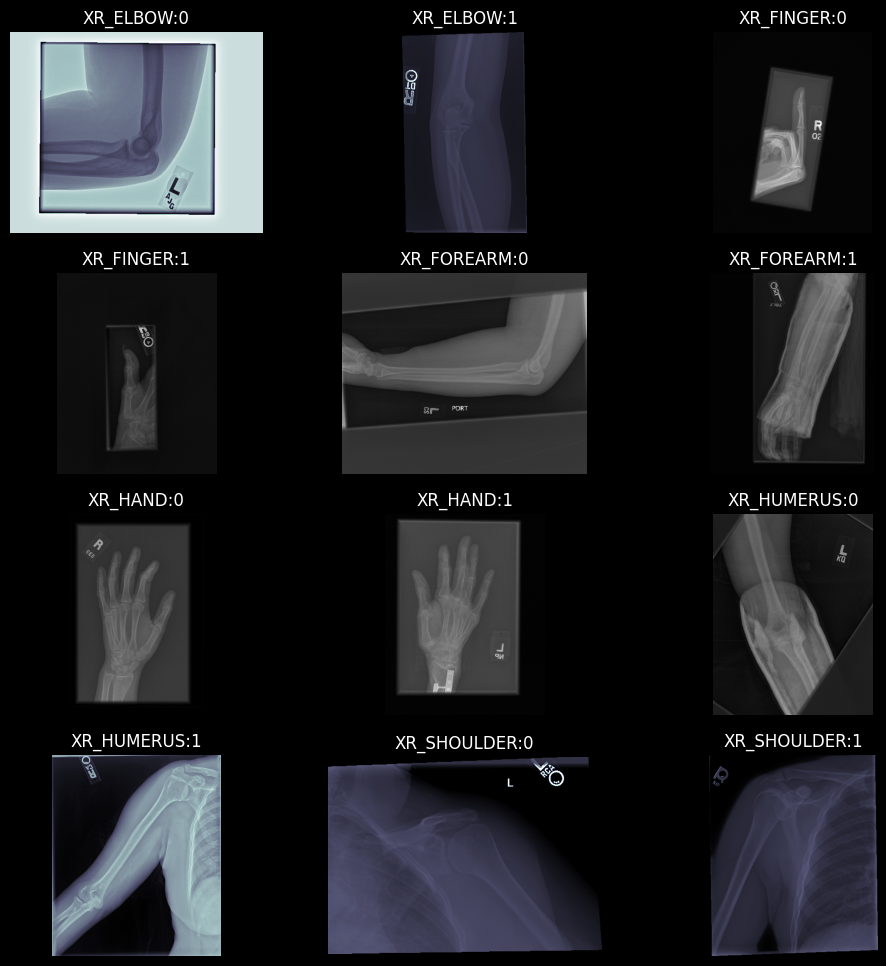

In [ ]:
#https://www.kaggle.com/kmader/mura-data-overview
from skimage.io import imread

sub_df = df_train.groupby(['body_part', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['xray_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{body_part}:{label}'.format(**c_row))

fig.savefig('samples.png', dpi = 300)

**Data preparation**

In [ ]:
train, valid = train_test_split(filtered_train,
                               test_size=0.2,
                               random_state=random_seed)
test = filtered_test.copy()

In [ ]:
image_generator_settings = dict(
                          rescale = 1. / 255
                          #samplewise_center = True,
                          #samplewise_std_normalization = True,
                          #rotation_range = 5,
                         )

image_generator = ImageDataGenerator(**image_generator_settings)

In [ ]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=random_seed)

Found 11805 non-validated image filenames.


In [ ]:
valid_generator = image_generator.flow_from_dataframe(
    dataframe = valid,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label', #'labels'
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=random_seed)

Found 2952 validated image filenames.


In [ ]:
test_generator = image_generator.flow_from_dataframe(
    dataframe = test,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label', #'labels'
    batch_size = 64,
    shuffle = False,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=random_seed)

Found 1312 validated image filenames.


# **Models**

**Global Callback**

In [ ]:
epochs = 100

early_stop = EarlyStopping(monitor="kappa",
                           mode="min",
                           patience=10,
                           restore_best_weights=True)

**CNN - Build**

We will use a Functional Model of tensorflow as it is more flexible (not Sequential, with add layers)

In [ ]:
def cnn_builder(
        input_shape=(256, 256, 3),
        starting_filters=32,
        conv_layers=1,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=False,
        pooling="max",
        dropout=None,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        last_pooling=None,
        spatial_dropout=None,
        last_dropout=None,
):

    # Define the input layer.
    inputs = Input(
        shape=input_shape,
        name="input"
    )

    x = inputs

    # Define the convolutional layers.
    for conv_level in range(conv_layers):

        current_filters = starting_filters * (2 ** conv_level)

        for conv_number in range(convs_per_layer):

            x = Conv2D(
                filters=current_filters,
                kernel_size=conv_kernel,
                strides=conv_strides,
                name=f"conv_{conv_level}_{conv_number}",
                padding='same'
            )(x)

            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)

            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)

        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)

        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)

        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)

    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)

    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name="flatten")(x)

    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)

    # Define the output layer.
    output = Dense(1, activation='sigmoid', name="output")(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=output)

    return model

**CNN - Baseline**

Loss: The training loss decreased consistently over the epochs, indicating that the model learned to minimize its training error. However, the validation and test losses increased after a certain point, suggesting that the model might be overfitting.

AUC: The AUC (Area Under the Curve) metric measures the model's ability to distinguish between positive and negative examples. In your case, the training AUC is relatively high (0.79262), indicating that the model performs well on the training data. However, the validation AUC (0.70181) and test AUC (0.59604) are lower, suggesting a decrease in performance on unseen data.

Accuracy: The training accuracy (0.71546) is higher than the validation accuracy (0.65142) and test accuracy (0.57317), indicating some degree of overfitting. The accuracy on the test set is relatively low, indicating that the model might be struggling to generalize to new examples.

Kappa: The Kappa coefficient measures the agreement between the predicted and true labels, considering the possibility of random agreement. The training Kappa (0.42074) is higher than the validation Kappa (0.2979) and test Kappa (0.14935), indicating a decline in performance on unseen data.

Based on these results, it's clear that the model is overfitting the training data and not generalizing well to new examples.

In [ ]:
cnn_model = cnn_builder(starting_filters=32,
                                      conv_layers=4,
                                      convs_per_layer=1,
                                      pooling='max')

cnn_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop])

print('Finished training.')

print('------------------')
cnn_model.summary()

Epoch 1/100
185/185 [==============================] - 111s 509ms/step - loss: 0.6734 - auc: 0.5825 - accuracy: 0.5633 - kappa: 0.0813 - val_loss: 0.6703 - val_auc: 0.6206 - val_accuracy: 0.5539 - val_kappa: 0.0678
Epoch 2/100
185/185 [==============================] - 83s 451ms/step - loss: 0.6523 - auc: 0.6429 - accuracy: 0.6035 - kappa: 0.1852 - val_loss: 0.6660 - val_auc: 0.6185 - val_accuracy: 0.5742 - val_kappa: 0.1317
Epoch 3/100
185/185 [==============================] - 84s 454ms/step - loss: 0.6334 - auc: 0.6793 - accuracy: 0.6318 - kappa: 0.2475 - val_loss: 0.7038 - val_auc: 0.6528 - val_accuracy: 0.5850 - val_kappa: 0.1860
Epoch 4/100
185/185 [==============================] - 81s 435ms/step - loss: 0.6111 - auc: 0.7148 - accuracy: 0.6562 - kappa: 0.2989 - val_loss: 0.6375 - val_auc: 0.6799 - val_accuracy: 0.6287 - val_kappa: 0.2460
Epoch 5/100
185/185 [==============================] - 81s 437ms/step - loss: 0.5849 - auc: 0.7471 - accuracy: 0.6755 - kappa: 0.3374 - val_los

In [ ]:
# save model
filename = 'models/cnn_baseline'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/cnn_baseline
21/21 [==============================] - 9s 418ms/step - loss: 0.7074 - auc: 0.5898 - accuracy: 0.5130 - kappa: 0.0360


Train Loss     : 0.20766
Validation Loss: 1.08166
Test Loss      : 0.70737
---
Train AUC     : 0.97423
Validation AUC: 0.69331
Test AUC      : 0.58983
---
Train Accuracy     : 0.91055
Validation Accuracy: 0.64634
Test Accuracy      : 0.51296
---
Train Kappa     : 0.81951
Validation Kappa: 0.81951
Test Kappa      : 0.03604



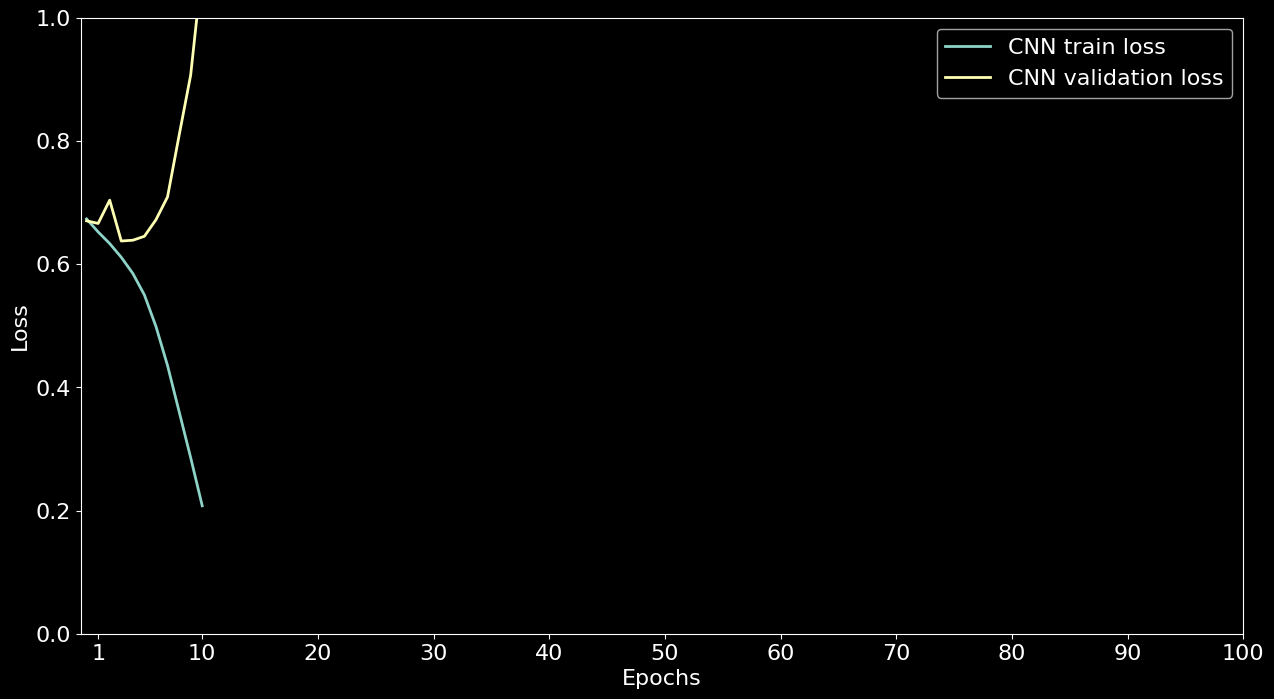

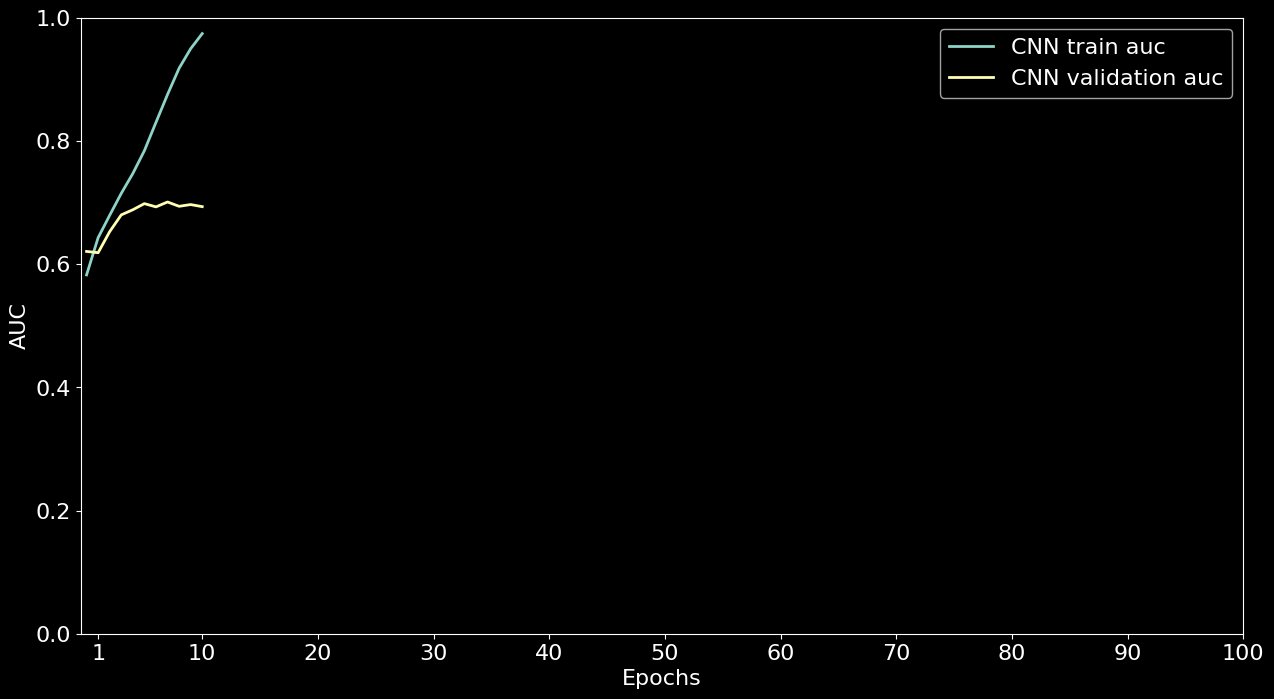

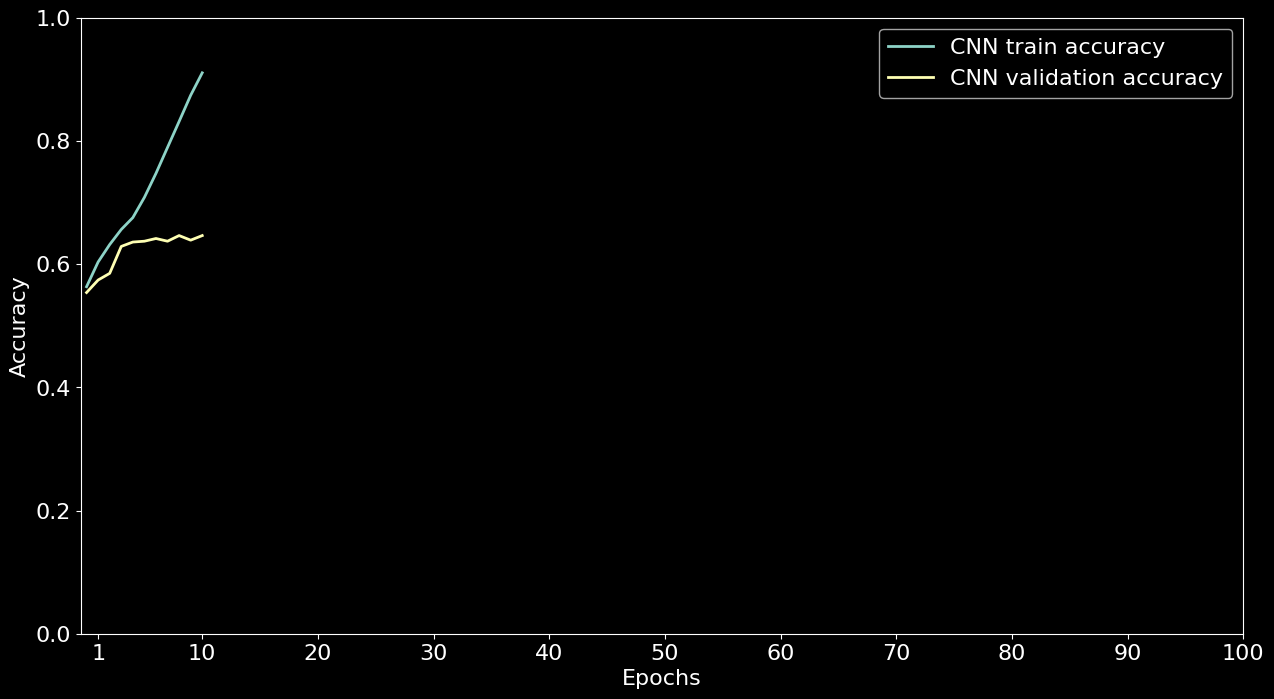

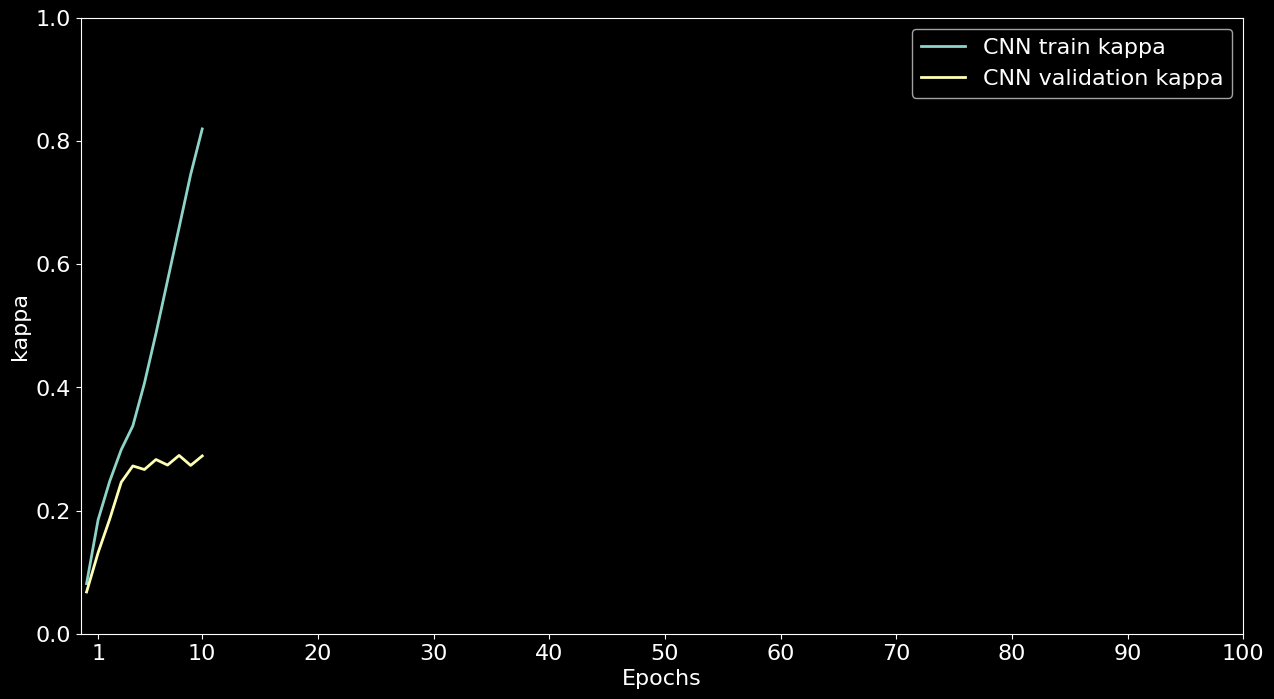

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

**CNN - Complex**

Based on these results, it seems that the more complex CNN model did not perform significantly better than the previous model. The training and validation losses improved slightly, but the test loss increased. The AUC, accuracy, and Kappa values also did not show significant improvements.


In [ ]:
cnn_model = cnn_builder(starting_filters=32,
                                conv_layers=4,
                                convs_per_layer=1,
                                pooling='avg',
                                batch_norm=True,
                                dropout=0.2,
                                pool_strides=(2, 2))

cnn_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop])

print('Finished training.')

print('------------------')
cnn_model.summary()

Epoch 1/100
185/185 [==============================] - 99s 504ms/step - loss: 1.0132 - auc: 0.5435 - accuracy: 0.5361 - kappa: 0.0602 - val_loss: 0.6868 - val_auc: 0.5501 - val_accuracy: 0.5379 - val_kappa: 0.0628
Epoch 2/100
185/185 [==============================] - 91s 491ms/step - loss: 0.8421 - auc: 0.5655 - accuracy: 0.5482 - kappa: 0.0838 - val_loss: 0.7417 - val_auc: 0.5577 - val_accuracy: 0.5312 - val_kappa: 0.0115
Epoch 3/100
185/185 [==============================] - 91s 489ms/step - loss: 0.7865 - auc: 0.5781 - accuracy: 0.5615 - kappa: 0.1100 - val_loss: 0.7511 - val_auc: 0.5796 - val_accuracy: 0.5600 - val_kappa: 0.1107
Epoch 4/100
185/185 [==============================] - 93s 500ms/step - loss: 0.7470 - auc: 0.6018 - accuracy: 0.5774 - kappa: 0.1413 - val_loss: 1.0319 - val_auc: 0.5968 - val_accuracy: 0.5305 - val_kappa: 0.0085
Epoch 5/100
185/185 [==============================] - 92s 496ms/step - loss: 0.7382 - auc: 0.6112 - accuracy: 0.5858 - kappa: 0.1581 - val_loss

In [ ]:
# save model
filename = 'models/cnn_complex'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/cnn_complex
21/21 [==============================] - 8s 364ms/step - loss: 0.6943 - auc: 0.5278 - accuracy: 0.5114 - kappa: 0.0260


Train Loss     : 0.64280
Validation Loss: 0.66572
Test Loss      : 0.69427
---
Train AUC     : 0.68781
Validation AUC: 0.65124
Test AUC      : 0.52782
---
Train Accuracy     : 0.63905
Validation Accuracy: 0.60467
Test Accuracy      : 0.51143
---
Train Kappa     : 0.26610
Validation Kappa: 0.26610
Test Kappa      : 0.02600



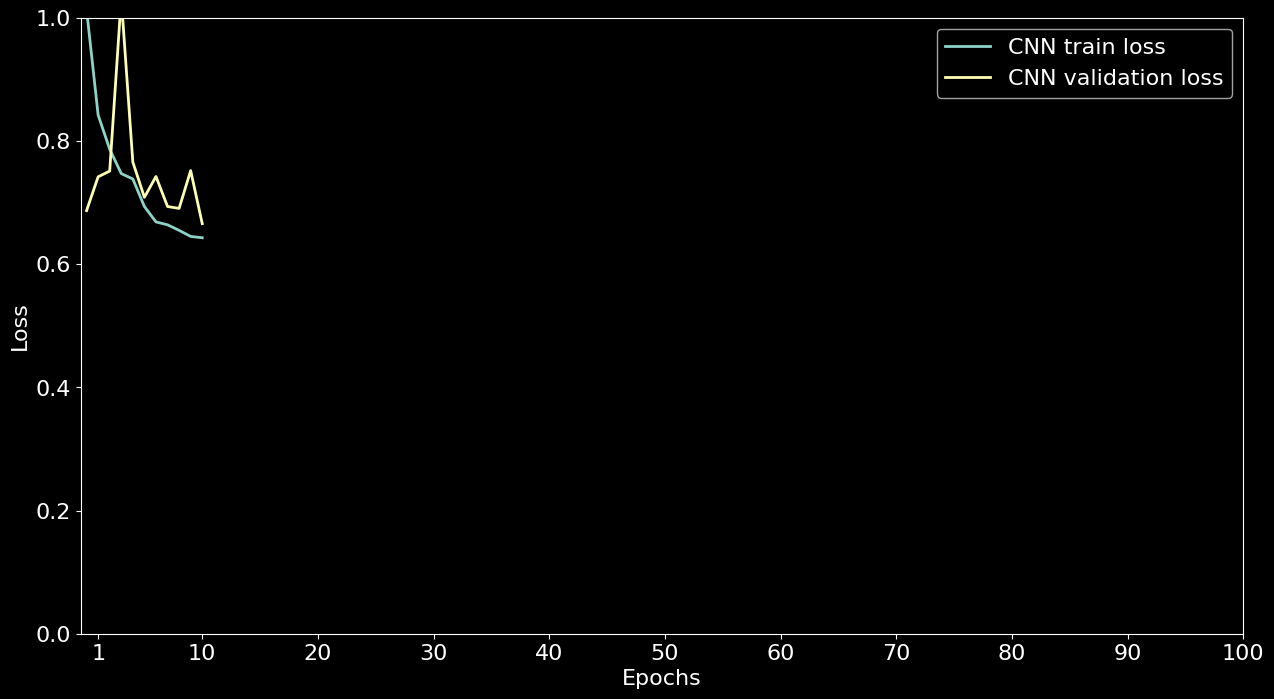

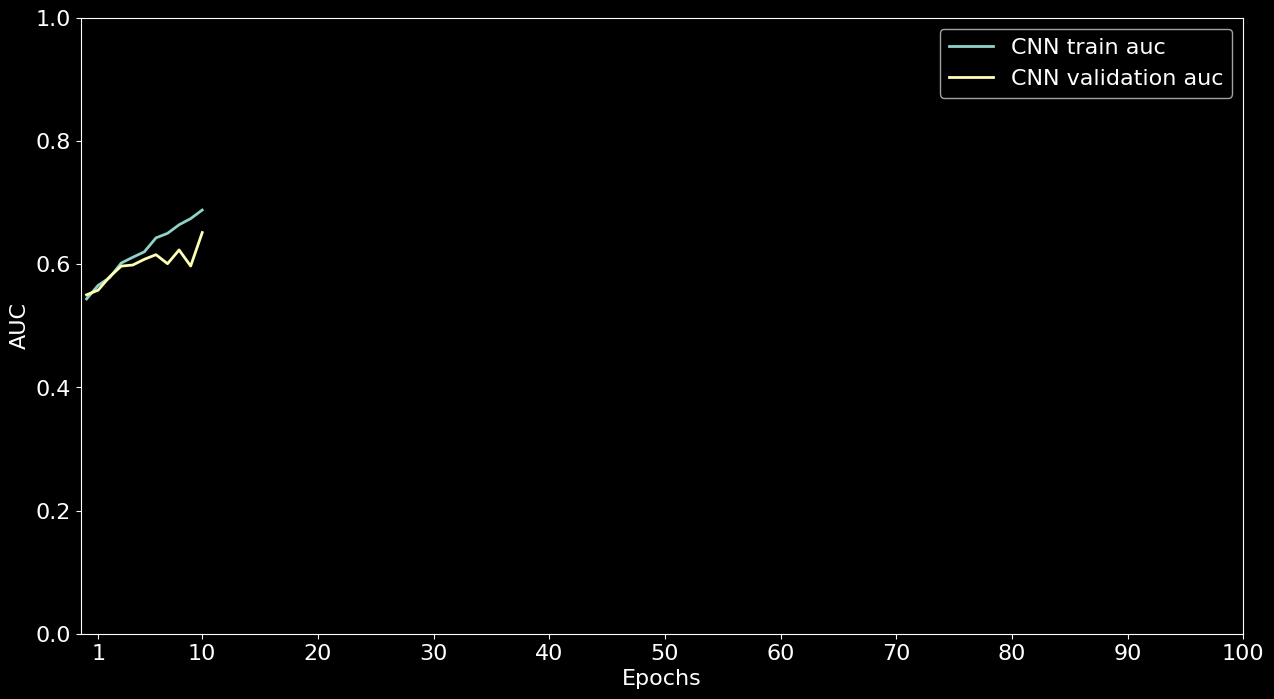

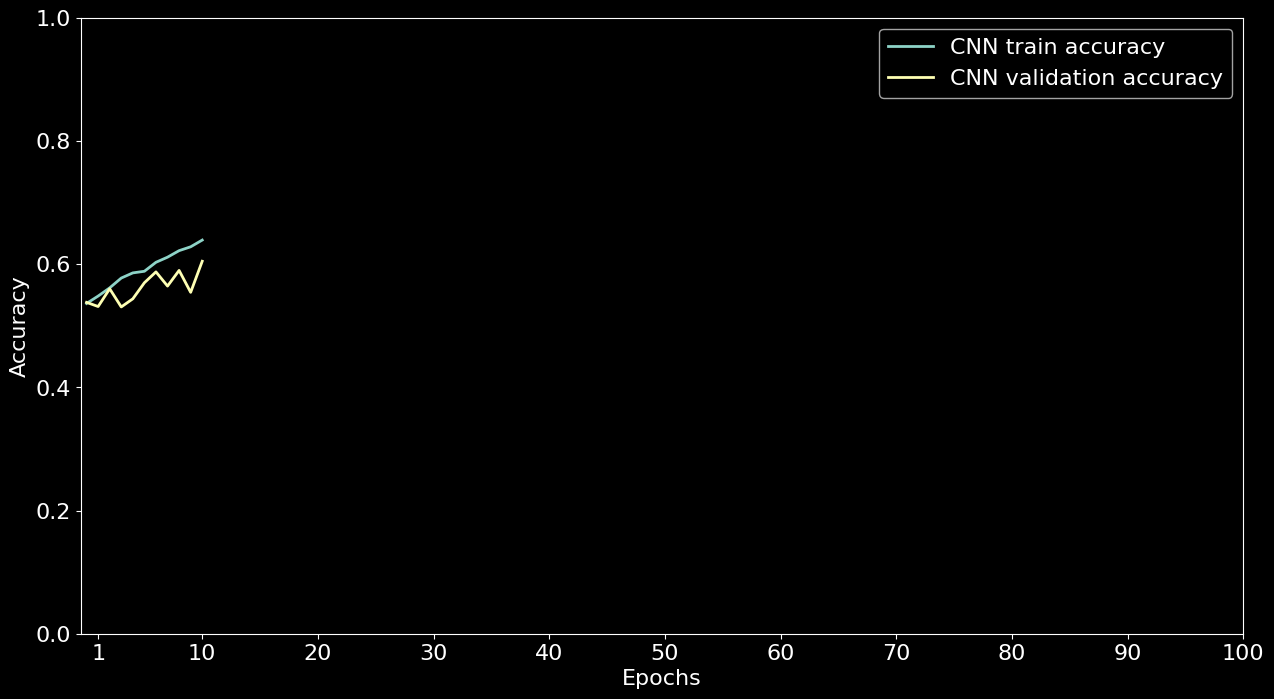

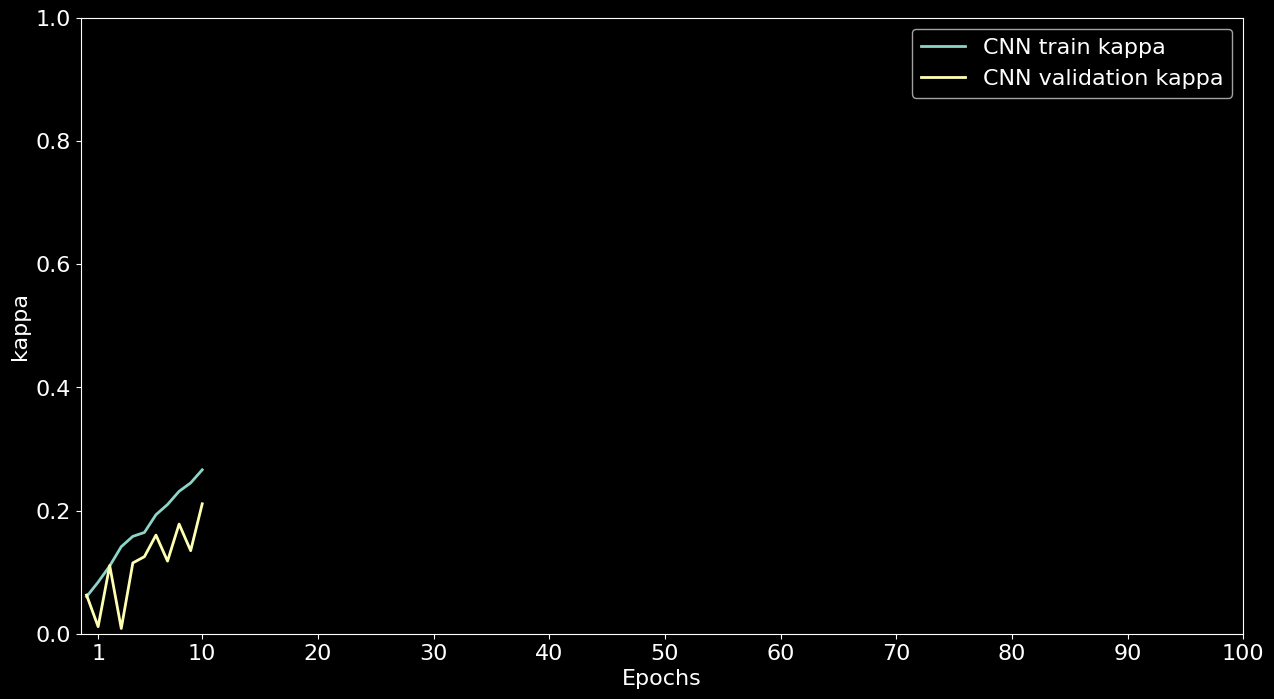

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)